In [17]:
!pip install pymorphy2 -q
!pip install tqdm -q
!pip install MulticoreTSNE -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
import pandas as pd
import numpy as np

import re
from tqdm import tqdm
import string
from MulticoreTSNE import MulticoreTSNE
import matplotlib.pyplot as plt
from pymorphy2 import MorphAnalyzer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df_deti_lem = pd.read_csv('/kaggle/input/mail-news/deti_tokens.csv')
df_dom_lem = pd.read_csv('/kaggle/input/mail-news/dom_tokens.csv')
df_health_lem = pd.read_csv('/kaggle/input/mail-news/health_tokens.csv')
df_kino_lem = pd.read_csv('/kaggle/input/mail-news/kino_tokens.csv')

In [7]:
df_deti_lem['target'] = 'deti'
df_dom_lem['target'] = 'dom'
df_health_lem['target'] = 'health'
df_kino_lem['target'] = 'kino'

In [8]:
df = pd.concat([df_deti_lem, df_dom_lem, df_health_lem, df_kino_lem], ignore_index=True)
df

,URL,Title,Description,Article Text,Keywords,tokens,target
0,https://deti.mail.ru/article/kostyumy-na-novyj...,Костюмы на Новый год для детей своими руками,Сделать новогодний наряд для сына или дочки св...,Костюм Снежинки В качестве основы для костюма ...,Дети 3-7 лет,"['костюм', 'снежинка', 'в', 'качество', 'основ...",deti
1,https://deti.mail.ru/article/esli-rebenok-veri...,Как создают детское новогоднее шоу: интервью с...,"Режиссер, сценарист и главный новогодний волше...",Если ребенок верит в сказку хотя бы до десяти ...,Семья,"['если', 'ребёнок', 'верить', 'сказка', 'хотя'...",deti
2,https://deti.mail.ru/article/gid-po-detskim-no...,30 крутых детских новогодних подарков на любой...,"Думаете о том, что подарить ребенку на Новый г...",Подарки до 1 000 рублей Наборы для создания сн...,Семья,"['подарок', 'рубль', 'набор', 'создание', 'сне...",deti
3,https://deti.mail.ru/article/chto-delat-esli-s...,"Что делать, если с ГВ не сложилось: 4 совета","Лучшая еда для младенца – это, конечно, мамино...",Чаще практикуйте контакт кожа к коже Период но...,1 месяц - 6 месяцев,"['частый', 'практиковать', 'контакт', 'кожа', ...",deti
4,https://deti.mail.ru/article/novyj-god-blizko-...,Новый год близко: как звезды с детьми наряжают...,Главный атрибут праздника уже появился в домах...,"На календаре почти середина декабря, и знамени...",Семья,"['на', 'календарь', 'середина', 'декабрь', 'зн...",deti
...,...,...,...,...,...,...,...
56716,https://kino.mail.ru/news/16973_novyj_koshmar_...,Новый «Кошмар на улице Вязов» будет очень стра...,Съемки новой версии знаменитого фильма ужасов ...,Съемки новой версии знаменитого фильма ужасов ...,НОВОСТЬ,"['съёмка', 'новый', 'версия', 'знаменитый', 'ф...",kino
56717,https://kino.mail.ru/news/16988_razbitaja_gita...,Разбитая гитара Курта Кобейна продана за 100 т...,"Разбитая гитара Курта Кобейна, выставленная на...","Разбитая гитара Курта Кобейна, выставленная на...",НОВОСТЬ,"['разбитый', 'гитара', 'курт', 'кобейн', 'выст...",kino
56718,https://kino.mail.ru/news/16977_no_doubt_otloz...,No Doubt отложили выпуск альбома до 2010 года,Возобновившая творческую деятельность группа N...,Возобновившая тв орческую деятельность группа ...,НОВОСТЬ,"['возобновить', 'тв', 'орческовать', 'деятельн...",kino
56719,https://kino.mail.ru/news/20971_po_podozreniju...,По подозрению в убийстве задержан сын Василия ...,Как рассказал источник в правоохранительных ор...,Как рассказал источник в правоохранительных ор...,НОВОСТЬ,"['как', 'рассказать', 'источник', 'правоохрани...",kino


In [9]:
df['Combined Text'] = df[['Title', 'Description', 'Article Text']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [10]:
df.drop(columns=['Title', 'Description', 'Article Text'], inplace=True)

In [11]:
df

,URL,Keywords,tokens,target,Combined Text
0,https://deti.mail.ru/article/kostyumy-na-novyj...,Дети 3-7 лет,"['костюм', 'снежинка', 'в', 'качество', 'основ...",deti,Костюмы на Новый год для детей своими руками С...
1,https://deti.mail.ru/article/esli-rebenok-veri...,Семья,"['если', 'ребёнок', 'верить', 'сказка', 'хотя'...",deti,Как создают детское новогоднее шоу: интервью с...
2,https://deti.mail.ru/article/gid-po-detskim-no...,Семья,"['подарок', 'рубль', 'набор', 'создание', 'сне...",deti,30 крутых детских новогодних подарков на любой...
3,https://deti.mail.ru/article/chto-delat-esli-s...,1 месяц - 6 месяцев,"['частый', 'практиковать', 'контакт', 'кожа', ...",deti,"Что делать, если с ГВ не сложилось: 4 совета Л..."
4,https://deti.mail.ru/article/novyj-god-blizko-...,Семья,"['на', 'календарь', 'середина', 'декабрь', 'зн...",deti,Новый год близко: как звезды с детьми наряжают...
...,...,...,...,...,...
56716,https://kino.mail.ru/news/16973_novyj_koshmar_...,НОВОСТЬ,"['съёмка', 'новый', 'версия', 'знаменитый', 'ф...",kino,Новый «Кошмар на улице Вязов» будет очень стра...
56717,https://kino.mail.ru/news/16988_razbitaja_gita...,НОВОСТЬ,"['разбитый', 'гитара', 'курт', 'кобейн', 'выст...",kino,Разбитая гитара Курта Кобейна продана за 100 т...
56718,https://kino.mail.ru/news/16977_no_doubt_otloz...,НОВОСТЬ,"['возобновить', 'тв', 'орческовать', 'деятельн...",kino,No Doubt отложили выпуск альбома до 2010 года ...
56719,https://kino.mail.ru/news/20971_po_podozreniju...,НОВОСТЬ,"['как', 'рассказать', 'источник', 'правоохрани...",kino,По подозрению в убийстве задержан сын Василия ...


In [12]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

In [13]:
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding='max_length')
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embeddings = outputs[0]
    sentence_embeddings = sentence_embeddings.mean(dim=1)
    sentence_embeddings = sentence_embeddings.cpu().numpy()
    return sentence_embeddings[0]

In [14]:
tqdm.pandas()
df['Embed_comb_text'] = df['Combined Text'].progress_map(lambda x: get_embeddings(x))

100%|██████████| 56721/56721 [06:23<00:00, 147.98it/s]


In [15]:
df.to_csv('/kaggle/working/all_df_tokens_bert.csv', index=False)

In [63]:
tsne = MulticoreTSNE(n_jobs=4) 
embedding_tsne = tsne.fit_transform(np.stack(df['Embed_comb_text'].values))

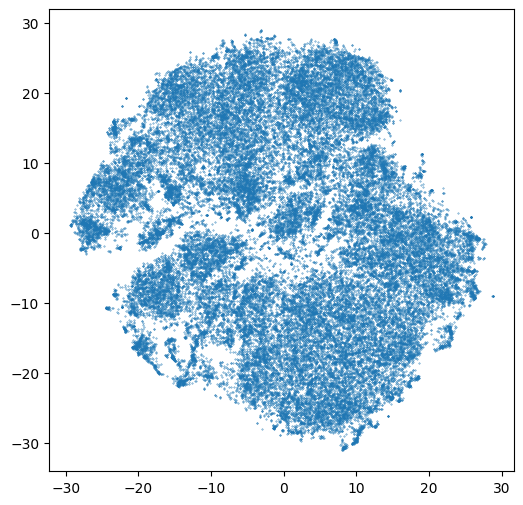

In [64]:
plt.figure(figsize=(6, 6))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], s=0.1)
plt.show()

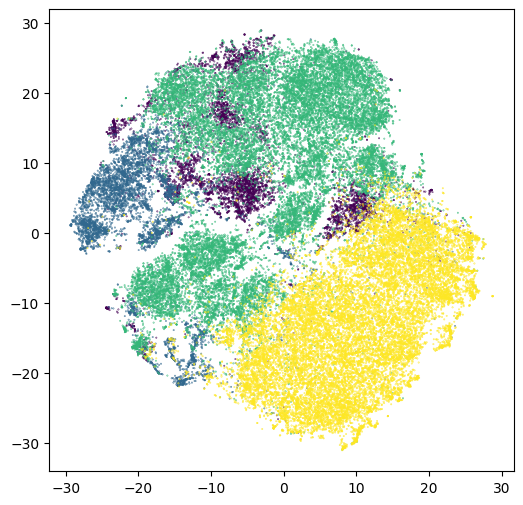

In [66]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

plt.figure(figsize=(6, 6))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1],c=le.fit_transform(df['target']), s=0.1)
plt.show()

In [101]:
embedding_tsne

array([[-23.12669675,  14.8727392 ],
       [ 17.10407614,   2.25988876],
       [-13.85796499,   6.49447278],
       ...,
       [  2.46335688, -27.09760179],
       [ -6.71142367, -12.59973194],
       [  6.00955652, -16.31301419]])

In [102]:
df['tsne_1'] = [x[0] for x in embedding_tsne]
df['tsne_2'] = [x[1] for x in embedding_tsne]
df

,URL,Keywords,tokens,target,Combined Text,Embed_comb_text,tsne_1,tsne_2
0,https://deti.mail.ru/article/kostyumy-na-novyj...,Дети 3-7 лет,"['костюм', 'снежинка', 'в', 'качество', 'основ...",deti,Костюмы на Новый год для детей своими руками С...,"[0.768645, 0.6252237, 0.04092919, -0.7410786, ...",-23.126697,14.872739
1,https://deti.mail.ru/article/esli-rebenok-veri...,Семья,"['если', 'ребёнок', 'верить', 'сказка', 'хотя'...",deti,Как создают детское новогоднее шоу: интервью с...,"[0.39564067, 0.8905004, -0.24187031, -0.671389...",17.104076,2.259889
2,https://deti.mail.ru/article/gid-po-detskim-no...,Семья,"['подарок', 'рубль', 'набор', 'создание', 'сне...",deti,30 крутых детских новогодних подарков на любой...,"[0.74010617, 0.4771761, -0.37752646, -0.66784,...",-13.857965,6.494473
3,https://deti.mail.ru/article/chto-delat-esli-s...,1 месяц - 6 месяцев,"['частый', 'практиковать', 'контакт', 'кожа', ...",deti,"Что делать, если с ГВ не сложилось: 4 совета Л...","[0.7905433, 0.612713, 0.018872663, -0.73737234...",-8.876258,16.743935
4,https://deti.mail.ru/article/novyj-god-blizko-...,Семья,"['на', 'календарь', 'середина', 'декабрь', 'зн...",deti,Новый год близко: как звезды с детьми наряжают...,"[0.59664834, 0.2422125, -0.3661027, -0.5502162...",9.856554,0.546784
...,...,...,...,...,...,...,...,...
56716,https://kino.mail.ru/news/16973_novyj_koshmar_...,НОВОСТЬ,"['съёмка', 'новый', 'версия', 'знаменитый', 'ф...",kino,Новый «Кошмар на улице Вязов» будет очень стра...,"[0.22399408, 0.41667312, -0.35615498, -0.19418...",6.846319,-20.991601
56717,https://kino.mail.ru/news/16988_razbitaja_gita...,НОВОСТЬ,"['разбитый', 'гитара', 'курт', 'кобейн', 'выст...",kino,Разбитая гитара Курта Кобейна продана за 100 т...,"[0.22220126, 0.4580818, -0.5270927, -0.2418852...",8.505621,-25.941501
56718,https://kino.mail.ru/news/16977_no_doubt_otloz...,НОВОСТЬ,"['возобновить', 'тв', 'орческовать', 'деятельн...",kino,No Doubt отложили выпуск альбома до 2010 года ...,"[0.4199062, 0.34677267, -0.32665637, 0.1646104...",2.463357,-27.097602
56719,https://kino.mail.ru/news/20971_po_podozreniju...,НОВОСТЬ,"['как', 'рассказать', 'источник', 'правоохрани...",kino,По подозрению в убийстве задержан сын Василия ...,"[-0.22972809, 0.022601396, -0.65659237, -0.125...",-6.711424,-12.599732


# deti

In [194]:
all_label = []

In [187]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
kmeans.fit(np.stack(df[df['target'] == 'deti']['Embed_comb_text'].values))
labels = kmeans.predict(np.stack(df[df['target'] == 'deti']['Embed_comb_text'].values))

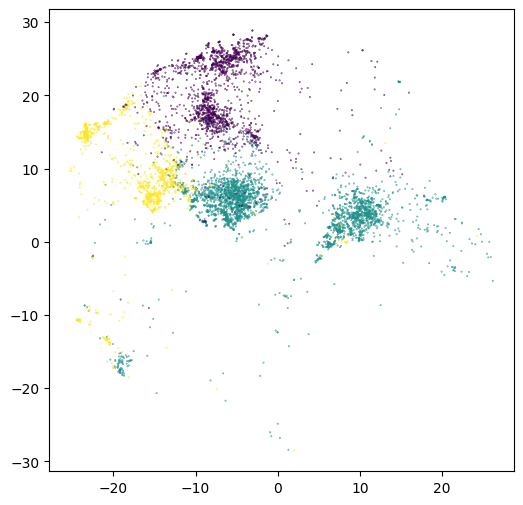

In [188]:
plt.figure(figsize=(6, 6))
plt.scatter(df[df['target'] == 'deti']['tsne_1'], df[df['target'] == 'deti']['tsne_2'],c=labels, s=0.1)
plt.show()

In [189]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


for i in range(3):
    temp_df = df[df['target'] == 'deti']
    temp_df['class'] = labels
    temp = temp_df[temp_df['class'] == i]
    words = []
    for val in temp['tokens'].values:
        words.extend(eval(val))
    print(i)
    print(Counter(words).most_common(20))
    print('-'*50)

0
[('ребёнок', 6439), ('это', 3120), ('который', 3041), ('в', 2498), ('беременность', 2492), ('малыш', 2208), ('время', 2009), ('мама', 1689), ('врач', 1539), ('женщина', 1513), ('организм', 1499), ('мочь', 1384), ('первый', 1370), ('год', 1363), ('такой', 1294), ('если', 1289), ('заболевание', 1285), ('случай', 1250), ('нужно', 1187), ('роды', 1170)]
--------------------------------------------------
1
[('ребёнок', 15604), ('это', 6423), ('который', 5261), ('год', 4882), ('свой', 4169), ('в', 3660), ('родитель', 3636), ('мама', 3295), ('время', 2869), ('такой', 2399), ('малыш', 2310), ('я', 2204), ('очень', 2172), ('семья', 2155), ('мочь', 2069), ('первый', 2061), ('а', 2032), ('жизнь', 2023), ('человек', 2006), ('день', 1962)]
--------------------------------------------------
2
[('ребёнок', 2623), ('в', 1523), ('который', 1433), ('это', 1303), ('отзыв', 1051), ('скидка', 985), ('очень', 960), ('такой', 879), ('другой', 828), ('малыш', 817), ('товар', 736), ('смотреть', 700), ('сдела

In [191]:
labels = labels.astype(str)
labels[labels == '0'] = 'беременность'
labels[labels == '1'] = 'Семья'
labels[labels == '2'] = 'Товары для детей'

In [195]:
all_label.append(labels)

# health

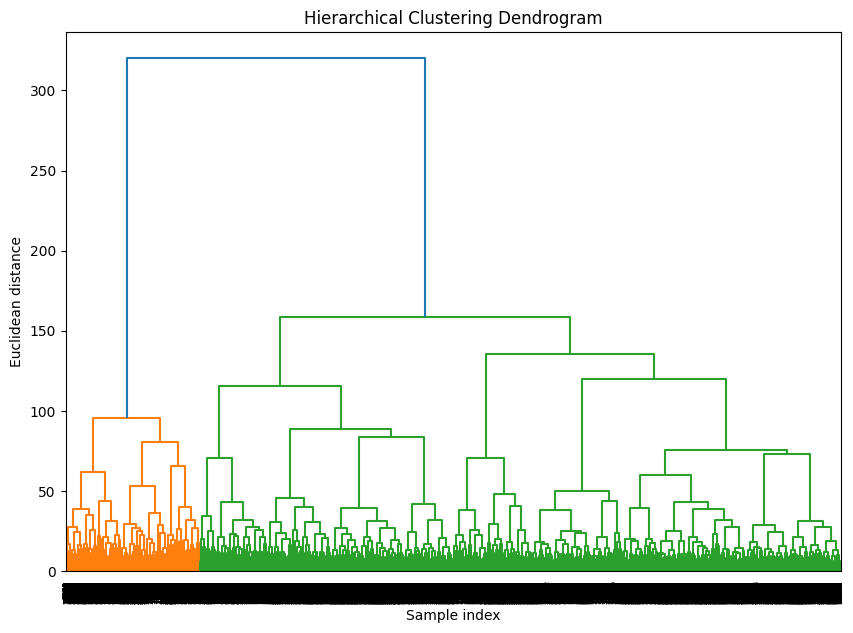

In [163]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Подготовка данных
data = np.stack(df[df['target'] == 'health']['Embed_comb_text'].values)

# Выполнение иерархической кластеризации
Z = linkage(data, 'ward')

# Построение дендрограммы
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

In [199]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
kmeans.fit(np.stack(df[df['target'] == 'health']['Embed_comb_text'].values))
labels = kmeans.predict(np.stack(df[df['target'] == 'health']['Embed_comb_text'].values))

In [198]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(np.stack(df[df['target'] == 'health']['Embed_comb_text'].values))
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


KeyboardInterrupt



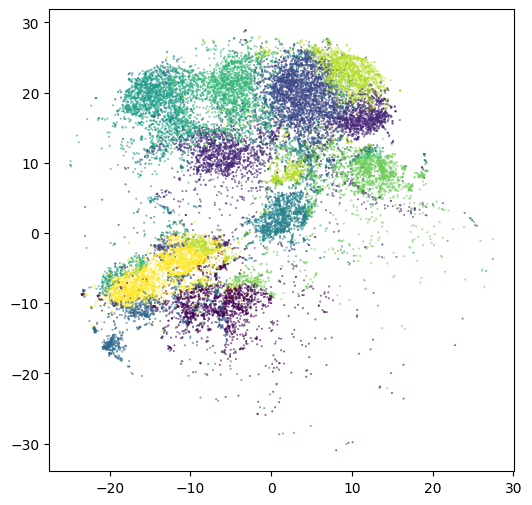

In [200]:
plt.figure(figsize=(6, 6))
plt.scatter(df[df['target'] == 'health']['tsne_1'], df[df['target'] == 'health']['tsne_2'],c=labels, s=0.1)
plt.show()

In [201]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


for i in range(10):
    temp_df = df[df['target'] == 'health']
    temp_df['class'] = labels
    temp = temp_df[temp_df['class'] == i]
    words = []
    for val in temp['tokens'].values:
        words.extend(eval(val))
    print(i, len(temp))
    print(Counter(words).most_common(20))
    print('-'*50)

0 1673
[('год', 1982), ('в', 1639), ('который', 1463), ('врач', 1090), ('человек', 955), ('по', 905), ('больница', 783), ('о', 699), ('это', 677), ('также', 655), ('время', 654), ('сообщать', 639), ('стать', 622), ('свой', 597), ('пациент', 582), ('россия', 569), ('медицинский', 560), ('слово', 545), ('женщина', 543), ('помощь', 498)]
--------------------------------------------------
1 3174
[('человек', 7922), ('который', 6432), ('это', 5954), ('в', 3820), ('свой', 3366), ('время', 3134), ('такой', 2936), ('исследование', 2784), ('год', 2441), ('учёный', 2275), ('жизнь', 2239), ('мочь', 2200), ('участник', 2194), ('тот', 2178), ('другой', 2114), ('один', 1958), ('работа', 1835), ('также', 1705), ('результат', 1697), ('день', 1618)]
--------------------------------------------------
2 3344
[('который', 7518), ('учёный', 5522), ('исследование', 5151), ('человек', 4930), ('в', 4567), ('клетка', 3964), ('это', 3207), ('результат', 3080), ('год', 3015), ('исследователь', 2935), ('пациент',

In [202]:
label_mapping = {
    '0': 'Медицинская помощь',
    '1': 'Научные исследования',
    '2': 'Биологические исследования',
    '3': 'Здоровое питание',
    '4': 'Медицинская помощь',
    '5': 'Здоровое питание',
    '6': 'Медицинские заболевания',
    '7': 'Медицинская помощь',
    '8': 'Медицинские исследования',
    '9': 'Научные исследования'
}

labels = np.array([label_mapping[str(label)] if str(label) in label_mapping else str(label) for label in labels])

In [203]:
all_label.append(labels)

# dom

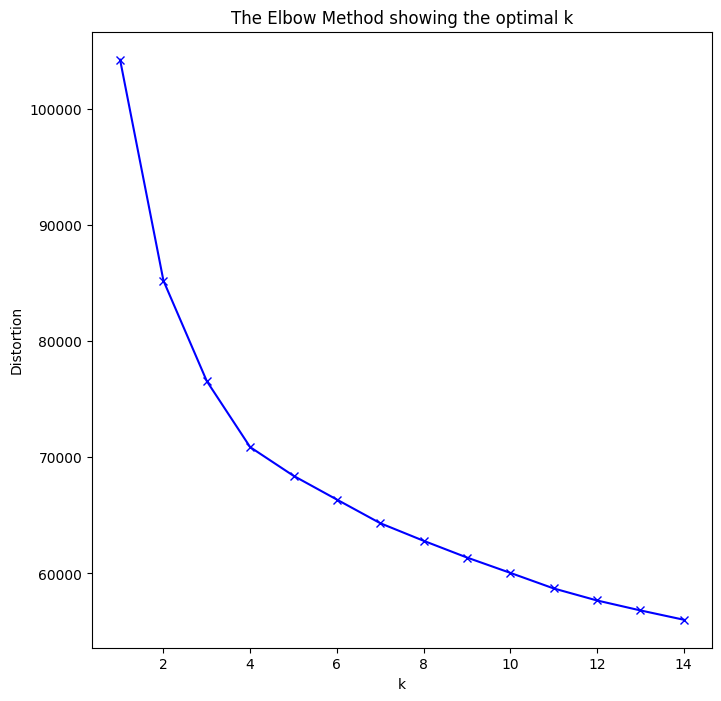

In [158]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(np.stack(df[df['target'] == 'dom']['Embed_comb_text'].values))
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [204]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans.fit(np.stack(df[df['target'] == 'dom']['Embed_comb_text'].values))
labels = kmeans.predict(np.stack(df[df['target'] == 'dom']['Embed_comb_text'].values))

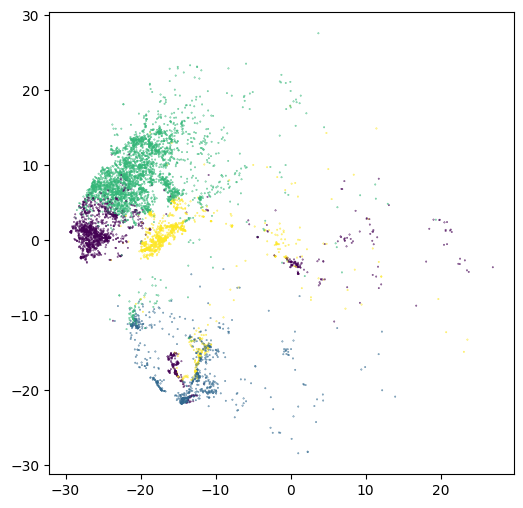

In [205]:
plt.figure(figsize=(6, 6))
plt.scatter(df[df['target'] == 'dom']['tsne_1'], df[df['target'] == 'dom']['tsne_2'],c=labels, s=0.1)
plt.show()

In [206]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


for i in range(4):
    temp_df = df[df['target'] == 'dom']
    temp_df['class'] = labels
    temp = temp_df[temp_df['class'] == i]
    words = []
    for val in temp['tokens'].values:
        words.extend(eval(val))
    print(i, len(temp))
    print(Counter(words).most_common(20))
    print('-'*50)

0 1533
[('в', 3077), ('дом', 2872), ('квартира', 2806), ('интерьер', 2751), ('который', 2597), ('комната', 2037), ('кухня', 2030), ('стена', 2008), ('спальня', 1828), ('это', 1827), ('зона', 1704), ('пространство', 1609), ('дизайнер', 1521), ('год', 1425), ('место', 1392), ('проект', 1267), ('гостиная', 1247), ('сделать', 1236), ('один', 1178), ('стиль', 1157)]
--------------------------------------------------
1 752
[('дом', 583), ('год', 583), ('в', 539), ('квартира', 433), ('который', 373), ('рубль', 277), ('это', 275), ('москва', 273), ('наш', 258), ('также', 248), ('по', 223), ('смотреть', 217), ('новый', 208), ('жильё', 207), ('эксперт', 198), ('город', 193), ('россия', 189), ('ранее', 188), ('слово', 184), ('самый', 183)]
--------------------------------------------------
2 3133
[('это', 5110), ('который', 5089), ('в', 4370), ('интерьер', 3700), ('стена', 3008), ('если', 2901), ('такой', 2782), ('использовать', 2698), ('цвет', 2692), ('место', 2529), ('комната', 2432), ('дом', 2

In [207]:
label_mapping = {
    '0': 'Домашний интерьер',
    '1': 'Недвижимость и цены',
    '2': 'Дизайн интерьера',
    '3': 'Рынок недвижимости'
}
labels = np.array([label_mapping[str(label)] if str(label) in label_mapping else str(label) for label in labels])

In [208]:
all_label.append(labels)

# kino

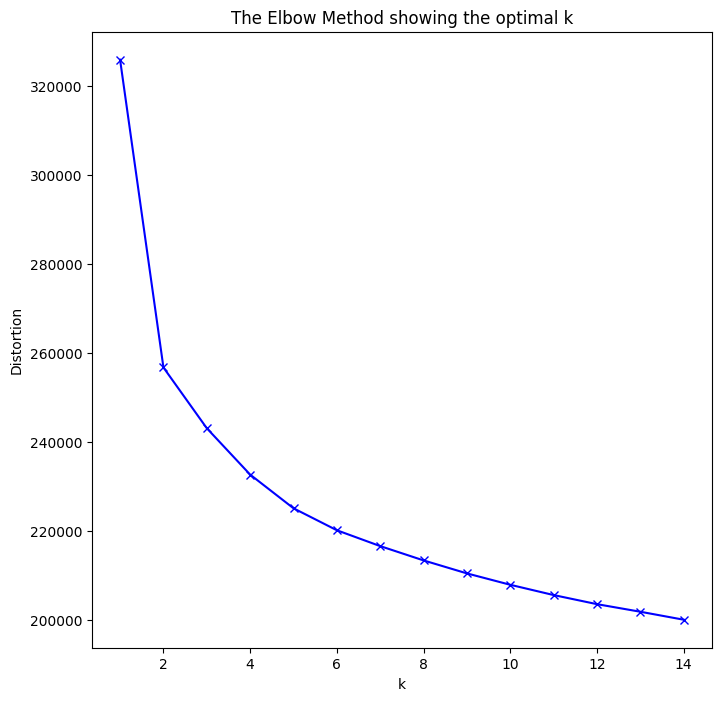

In [170]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(np.stack(df[df['target'] == 'kino']['Embed_comb_text'].values))
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [209]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
kmeans.fit(np.stack(df[df['target'] == 'kino']['Embed_comb_text'].values))
labels = kmeans.predict(np.stack(df[df['target'] == 'kino']['Embed_comb_text'].values))

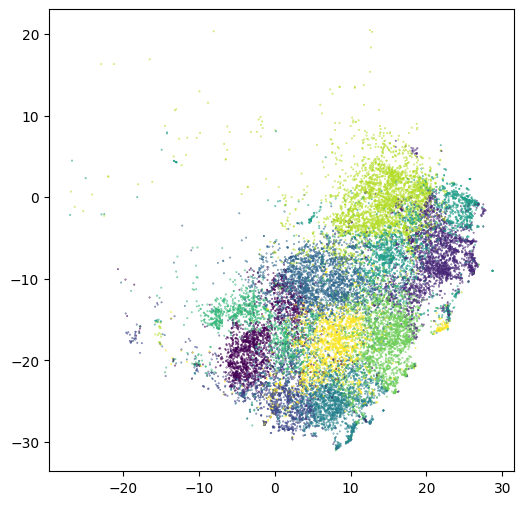

In [210]:
plt.figure(figsize=(6, 6))
plt.scatter(df[df['target'] == 'kino']['tsne_1'], df[df['target'] == 'kino']['tsne_2'],c=labels, s=0.1)
plt.show()

In [211]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


for i in range(10):
    temp_df = df[df['target'] == 'kino']
    temp_df['class'] = labels
    temp = temp_df[temp_df['class'] == i]
    words = []
    for val in temp['tokens'].values:
        words.extend(eval(val))
    print(i, len(temp))
    print(Counter(words).most_common(20))
    print('-'*50)

0 1752
[('свой', 1478), ('который', 1467), ('год', 1379), ('актриса', 1331), ('в', 878), ('писать', 833), ('певица', 830), ('это', 829), ('стать', 755), ('летний', 735), ('ребёнок', 656), ('время', 651), ('звезда', 644), ('я', 633), ('новый', 601), ('день', 549), ('фото', 539), ('фильм', 497), ('один', 474), ('очень', 469)]
--------------------------------------------------
1 2483
[('год', 6252), ('фильм', 5989), ('который', 4577), ('в', 3890), ('роль', 3473), ('актёр', 2454), ('режиссёр', 2440), ('картина', 2312), ('стать', 2177), ('свой', 2090), ('также', 1809), ('сериал', 1779), ('новый', 1741), ('главный', 1678), ('первый', 1671), ('это', 1647), ('хороший', 1539), ('актриса', 1453), ('один', 1385), ('сыграть', 1297)]
--------------------------------------------------
2 1338
[('год', 1165), ('который', 997), ('фильм', 788), ('в', 747), ('новый', 605), ('сериал', 580), ('стать', 507), ('свой', 505), ('первый', 461), ('проект', 410), ('шоу', 391), ('актёр', 343), ('роль', 334), ('такж

In [212]:
# Определите словарь для отображения старых меток на новые метки
label_mapping = {
    '0': 'Актрисы и певицы',
    '1': 'Фильмы и режиссеры',
    '2': 'Новые сериалы',
    '3': 'Актеры и жизнь',
    '4': 'Актеры и фильмы',
    '5': 'Кино и сериалы',
    '6': 'Актеры и суды',
    '7': 'Фильмы и режиссеры',
    '8': 'Актеры и жизнь',
    '9': 'Новые фильмы и сериалы'
}

# Замените старые метки на новые метки
labels = np.array([label_mapping[str(label)] if str(label) in label_mapping else str(label) for label in labels])

In [213]:
all_label.append(labels)

In [217]:
type(all_label[0])

numpy.ndarray

In [ ]:
[i for i in range]

In [222]:
flattened_all_label = [item for sublist in all_label for item in sublist]
flattened_all_label[:10]

['Товары для ',
 'Семья',
 'Товары для ',
 'беременност',
 'Семья',
 'Семья',
 'беременност',
 'Товары для ',
 'Товары для ',
 'Товары для ']

In [223]:
flattened_all_label_np = np.array(flattened_all_label)
np.save('/kaggle/working/flattened_all_label.npy', flattened_all_label_np)

In [225]:
df['class'] = flattened_all_label_np
df

,URL,Keywords,tokens,target,Combined Text,Embed_comb_text,tsne_1,tsne_2,class
0,https://deti.mail.ru/article/kostyumy-na-novyj...,Дети 3-7 лет,"['костюм', 'снежинка', 'в', 'качество', 'основ...",deti,Костюмы на Новый год для детей своими руками С...,"[0.768645, 0.6252237, 0.04092919, -0.7410786, ...",-23.126697,14.872739,Товары для
1,https://deti.mail.ru/article/esli-rebenok-veri...,Семья,"['если', 'ребёнок', 'верить', 'сказка', 'хотя'...",deti,Как создают детское новогоднее шоу: интервью с...,"[0.39564067, 0.8905004, -0.24187031, -0.671389...",17.104076,2.259889,Семья
2,https://deti.mail.ru/article/gid-po-detskim-no...,Семья,"['подарок', 'рубль', 'набор', 'создание', 'сне...",deti,30 крутых детских новогодних подарков на любой...,"[0.74010617, 0.4771761, -0.37752646, -0.66784,...",-13.857965,6.494473,Товары для
3,https://deti.mail.ru/article/chto-delat-esli-s...,1 месяц - 6 месяцев,"['частый', 'практиковать', 'контакт', 'кожа', ...",deti,"Что делать, если с ГВ не сложилось: 4 совета Л...","[0.7905433, 0.612713, 0.018872663, -0.73737234...",-8.876258,16.743935,беременност
4,https://deti.mail.ru/article/novyj-god-blizko-...,Семья,"['на', 'календарь', 'середина', 'декабрь', 'зн...",deti,Новый год близко: как звезды с детьми наряжают...,"[0.59664834, 0.2422125, -0.3661027, -0.5502162...",9.856554,0.546784,Семья
...,...,...,...,...,...,...,...,...,...
56716,https://kino.mail.ru/news/16973_novyj_koshmar_...,НОВОСТЬ,"['съёмка', 'новый', 'версия', 'знаменитый', 'ф...",kino,Новый «Кошмар на улице Вязов» будет очень стра...,"[0.22399408, 0.41667312, -0.35615498, -0.19418...",6.846319,-20.991601,Новые фильмы и сериалы
56717,https://kino.mail.ru/news/16988_razbitaja_gita...,НОВОСТЬ,"['разбитый', 'гитара', 'курт', 'кобейн', 'выст...",kino,Разбитая гитара Курта Кобейна продана за 100 т...,"[0.22220126, 0.4580818, -0.5270927, -0.2418852...",8.505621,-25.941501,Актеры и фильмы
56718,https://kino.mail.ru/news/16977_no_doubt_otloz...,НОВОСТЬ,"['возобновить', 'тв', 'орческовать', 'деятельн...",kino,No Doubt отложили выпуск альбома до 2010 года ...,"[0.4199062, 0.34677267, -0.32665637, 0.1646104...",2.463357,-27.097602,Новые сериалы
56719,https://kino.mail.ru/news/20971_po_podozreniju...,НОВОСТЬ,"['как', 'рассказать', 'источник', 'правоохрани...",kino,По подозрению в убийстве задержан сын Василия ...,"[-0.22972809, 0.022601396, -0.65659237, -0.125...",-6.711424,-12.599732,Актеры и суды


In [237]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = np.stack(df['Embed_comb_text'].values)
Y = le.fit_transform(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
model = CatBoostClassifier(loss_function='MultiClass', task_type='GPU')
model.fit(X_train, y_train, verbose=False)
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1177
           1       0.78      0.87      0.82       266
           2       0.89      0.94      0.92       399
           3       0.86      0.89      0.87       350
           4       0.18      0.12      0.15       669
           5       0.36      0.50      0.42       627
           6       0.21      0.06      0.10       307
           7       0.32      0.24      0.27       707
           8       0.87      0.85      0.86       408
           9       0.29      0.40      0.34      1114
          10       0.21      0.06      0.09       527
          11       0.07      0.02      0.03       493
          12       0.23      0.36      0.28      1125
          13       0.06      0.01      0.01       150
          14       0.86      0.87      0.86       268
          15       0.87      0.87      0.87       366
          16       0.19      0.06      0.09       213
          17       0.79    

In [238]:
predictions = model.predict(X_test)

# Get the class names from the label encoder
class_names = le.inverse_transform(list(set(y_test)))

# Generate the classification report
report = classification_report(y_test, predictions, target_names=class_names, zero_division=1)

print(report)

                            precision    recall  f1-score   support

            Актеры и жизнь       0.82      0.89      0.85      1177
             Актеры и суды       0.78      0.87      0.82       266
           Актеры и фильмы       0.89      0.94      0.92       399
          Актрисы и певицы       0.86      0.89      0.87       350
Биологические исследования       0.18      0.12      0.15       669
          Дизайн интерьера       0.36      0.50      0.42       627
         Домашний интерьер       0.21      0.06      0.10       307
          Здоровое питание       0.32      0.24      0.27       707
            Кино и сериалы       0.87      0.85      0.86       408
        Медицинская помощь       0.29      0.40      0.34      1114
   Медицинские заболевания       0.21      0.06      0.09       527
  Медицинские исследования       0.07      0.02      0.03       493
      Научные исследования       0.23      0.36      0.28      1125
       Недвижимость и цены       0.06      0.01